In [2]:
import os
import itertools
from PIL import Image

# Data Handling Tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Generate data paths with labels
train_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
filepaths = []
labels = []
folds = os.listdir(train_data_dir) # List of All directory with Train Directory, return 'PNEUMNONIA' & 'NORMAL'
for fold in folds:
    foldpath = os.path.join(train_data_dir,fold)
    fileList = os.listdir(foldpath)
    for file in fileList:
        fpath = os.path.join(foldpath,file)
        filepaths.append(fpath)
        labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='labels')

# Create a New DataFrame
train_df = pd.concat([FSeries, LSeries], axis=1)
train_df

,filepaths,labels
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
...,...,...
5211,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5212,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5213,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5214,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


In [5]:
# Generate data paths with labels
test_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
filepaths = []
labels = []
folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir,fold)
    fileList = os.listdir(foldpath)
    for file in fileList:
        fpath = os.path.join(foldpath,file)
        filepaths.append(fpath)
        labels.append(fold)
FSeries = pd.Series(filepaths,name='filepaths')
LSeries = pd.Series(labels,name='labels')
test_df = pd.concat([FSeries,LSeries], axis=1)
test_df

,filepaths,labels
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
...,...,...
619,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
620,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
621,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
622,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


In [6]:
# Generate data paths with labels
val_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
filepaths = []
labels = []
folds = os.listdir(val_data_dir)
for fold in folds:
    foldpath = os.path.join(val_data_dir,fold)
    fileList = os.listdir(foldpath)
    for file in fileList:
        fpath = os.path.join(foldpath,file)
        filepaths.append(fpath)
        labels.append(fold)
FSeries = pd.Series(filepaths,name='filepaths')
LSeries = pd.Series(labels,name='labels')
valid_df = pd.concat([FSeries,LSeries], axis=1)
valid_df

,filepaths,labels
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
5,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
6,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
7,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
8,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
9,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


# Preprocessing

In [7]:
# PreProcessing
batch_size = 16
img_size = (224, 224)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',target_size = img_size, class_mode = 'categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',target_size = img_size, class_mode = 'categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = val_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',target_size = img_size, class_mode = 'categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 5216 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.


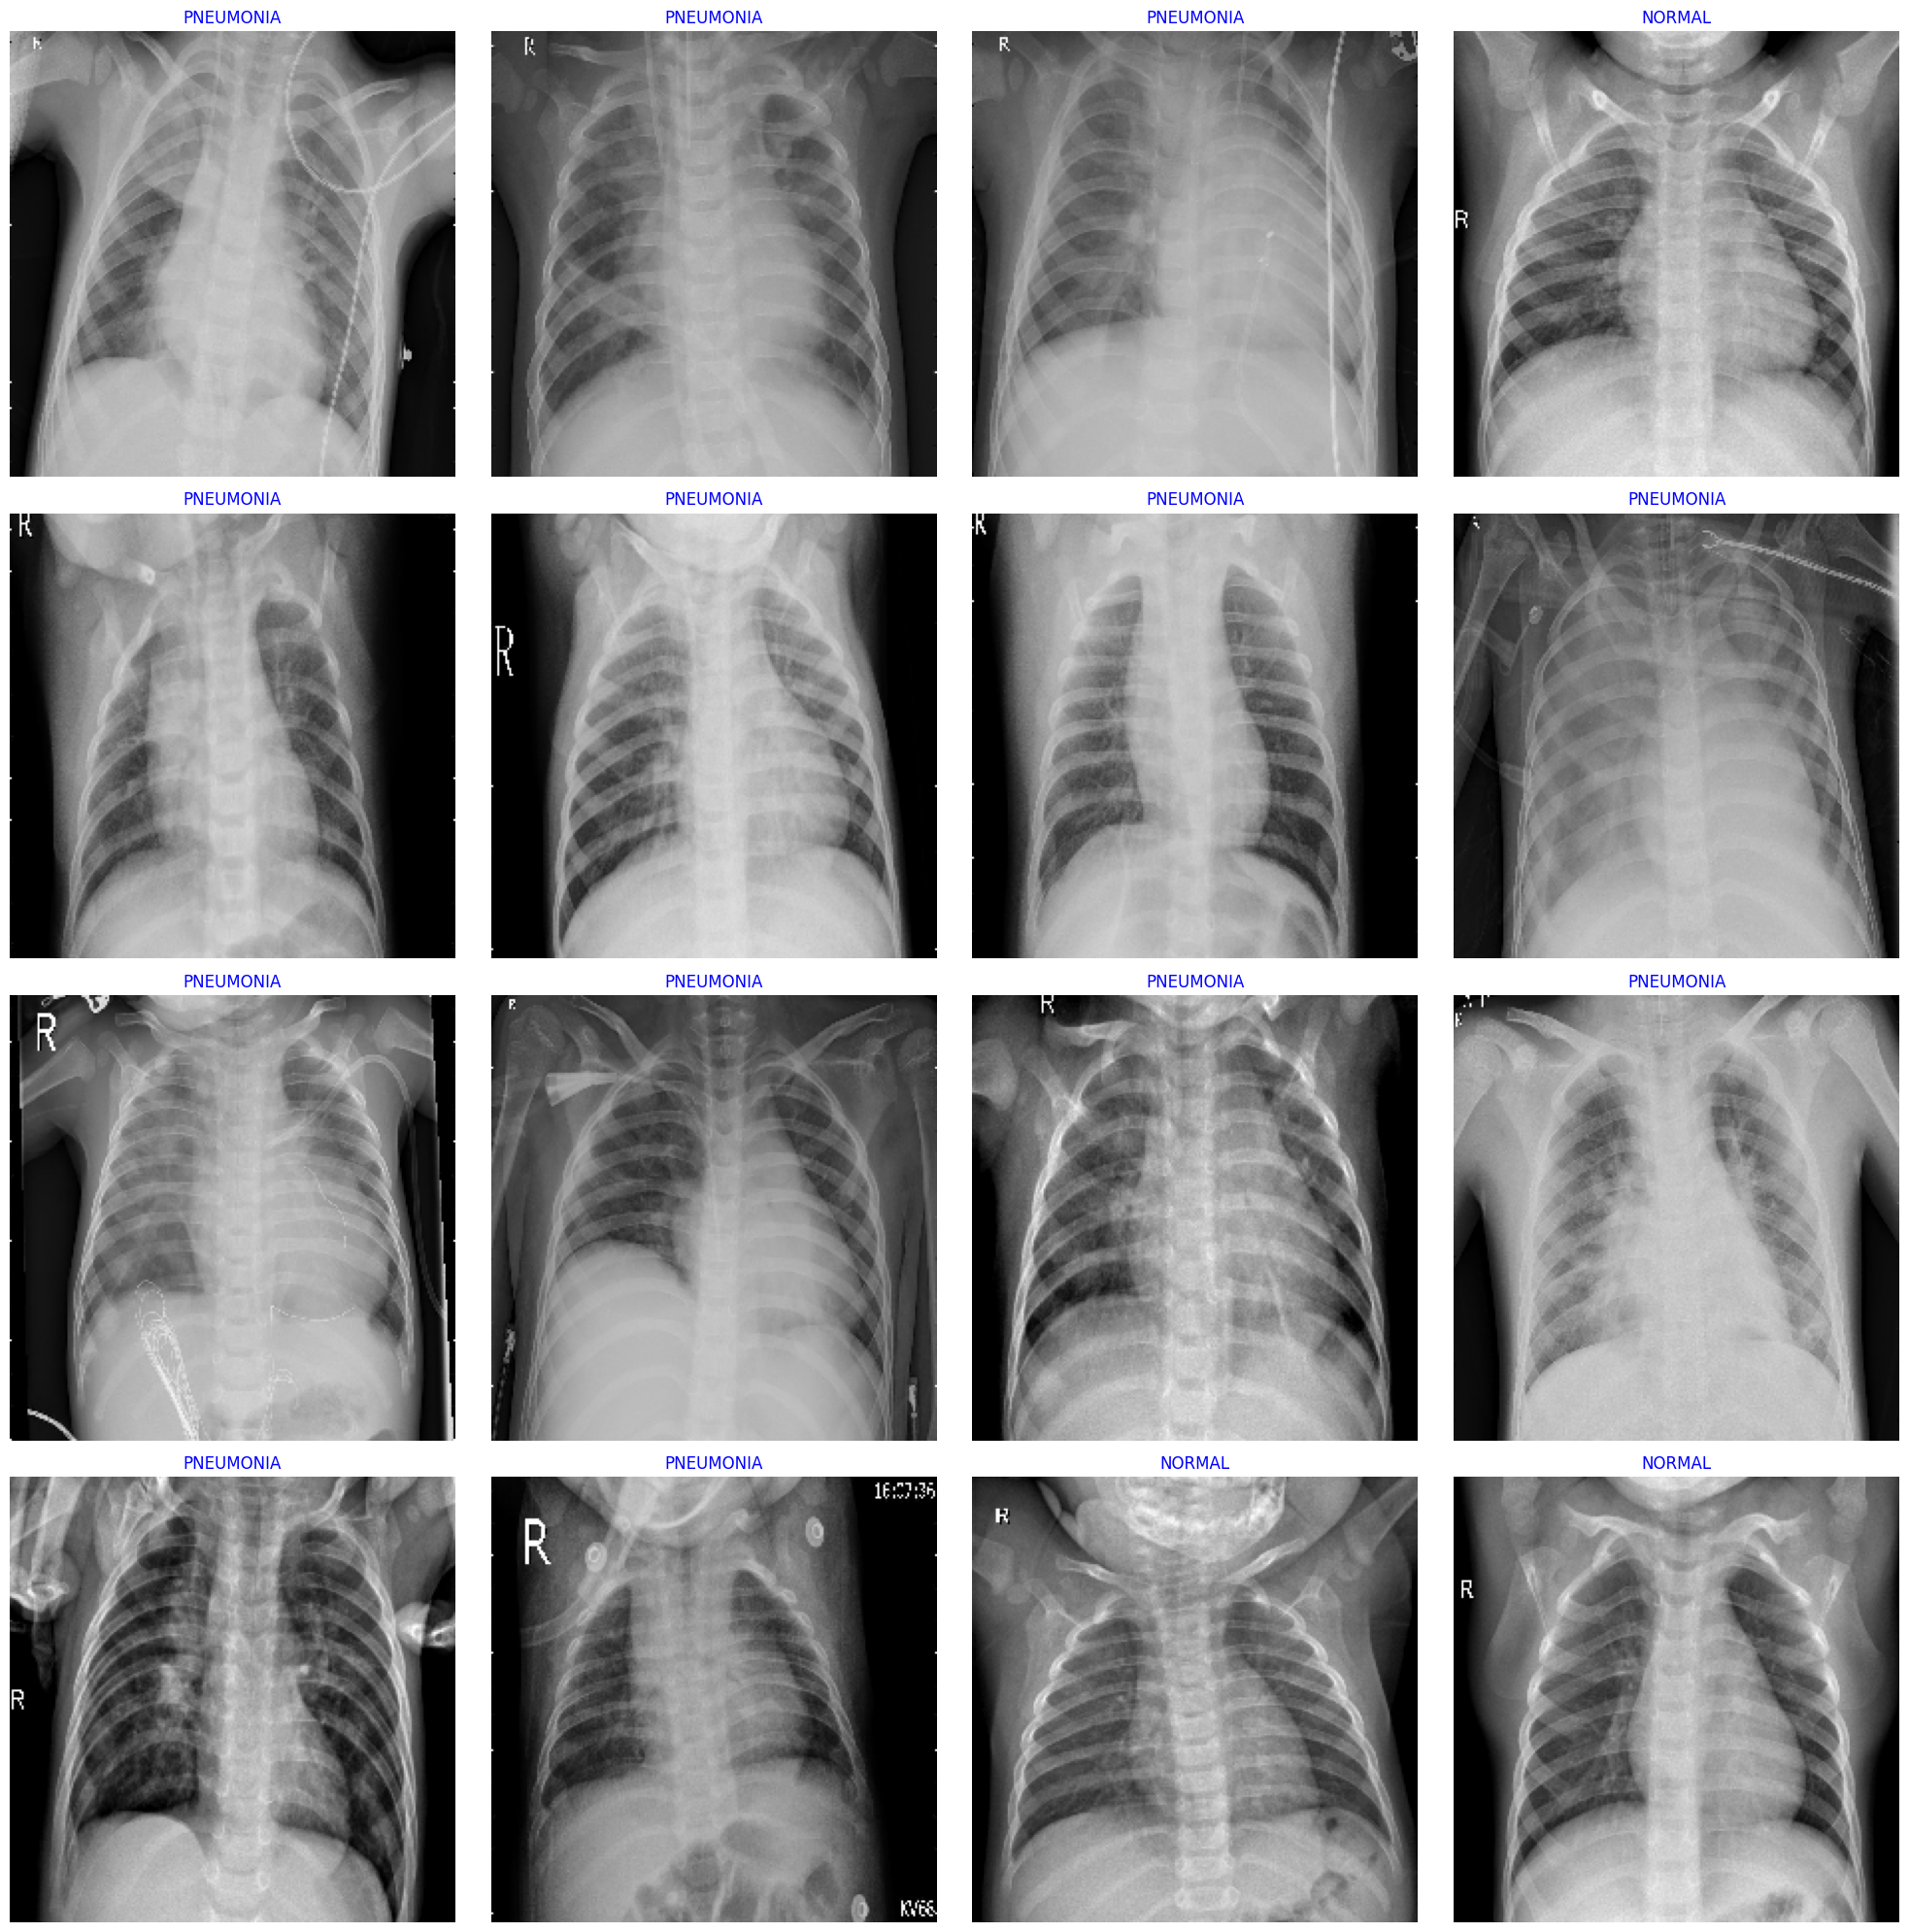

In [8]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)
plt.figure(figsize=(20,20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name,color='blue', fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
# CNN Model
img_size = (224, 224)
channels = 3
img_shape = (img_size[0],img_size[1],channels)
class_count = len(list(train_gen.class_indices.keys())) # 2

# VGG16
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=img_shape))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(class_count,activation='softmax'))

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [10]:
# Training the data
epochs = 13
history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/13
326/326 [==============================] - 89s 212ms/step - loss: 4.3869 - accuracy: 0.8094 - val_loss: 0.7616 - val_accuracy: 0.6875
Epoch 2/13
326/326 [==============================] - 70s 213ms/step - loss: 0.1671 - accuracy: 0.9356 - val_loss: 0.6474 - val_accuracy: 0.8125
Epoch 3/13
326/326 [==============================] - 71s 218ms/step - loss: 0.1043 - accuracy: 0.9613 - val_loss: 0.5412 - val_accuracy: 0.8125
Epoch 4/13
326/326 [==============================] - 71s 219ms/step - loss: 0.0836 - accuracy: 0.9699 - val_loss: 0.5153 - val_accuracy: 0.6875
Epoch 5/13
326/326 [==============================] - 71s 217ms/step - loss: 0.0638 - accuracy: 0.9739 - val_loss: 0.4737 - val_accuracy: 0.8750
Epoch 6/13
326/326 [==============================] - 81s 247ms/step - loss: 0.0492 - accuracy: 0.9820 - val_loss: 0.8243 - val_accuracy: 0.7500
Epoch 7/13
326/326 [==============================] - 72s 219ms/step - loss: 0.0486 - accuracy: 0.9837 - val_loss: 1.4336 - val_ac

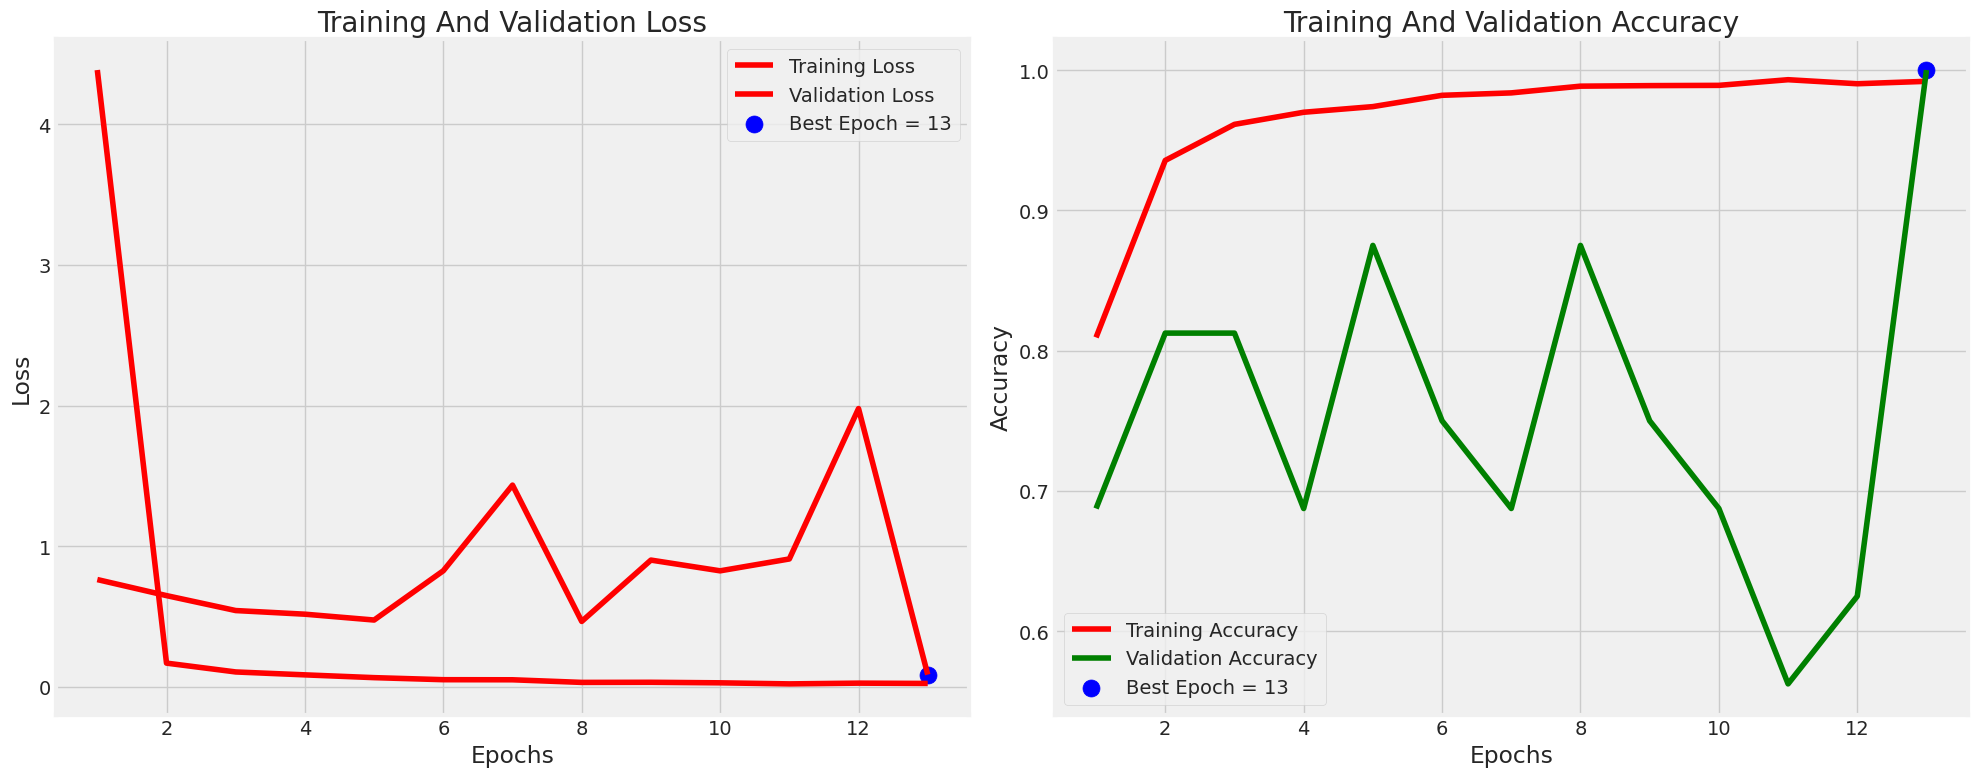

In [11]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

# Plot Training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label = 'Training Loss')
plt.plot(Epochs, val_loss, 'r', label = 'Validation Loss')
plt.scatter(index_loss + 1,val_lowest,s = 150, c = 'blue', label=loss_label)
plt.title('Training And Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label = 'Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s = 150, c = 'blue', label = acc_label)
plt.title('Training And Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
# Model Evaluation
train_score = model.evaluate(train_gen, verbose=1)
valid_score =   model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy", train_score[1])
print('-' * 20)

print("Validation Loss: ", valid_score[0])
print("Validation Accuracy", valid_score[1])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy", test_score[1])
print('-' * 20)

39/39 [==============================] - 5s 137ms/step - loss: 1.8137 - accuracy: 0.7612
Train Loss:  0.01460814755409956
Train Accuracy 0.9950153231620789
--------------------
Validation Loss:  0.08536729961633682
Validation Accuracy 1.0
--------------------
Test Loss:  1.813671350479126
Test Accuracy 0.7612179517745972
--------------------


In [14]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

In [15]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       0.37      0.14      0.20       234
   PNEUMONIA       0.62      0.86      0.72       390

    accuracy                           0.59       624
   macro avg       0.50      0.50      0.46       624
weighted avg       0.53      0.59      0.53       624



In [16]:
model.save('Pneumonia.h5')